### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is 96.53 percent.


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


170498071/170498071 [==============================] - 3s 0us/step


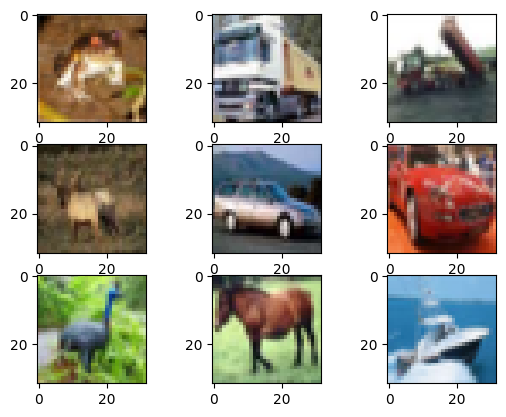

In [3]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

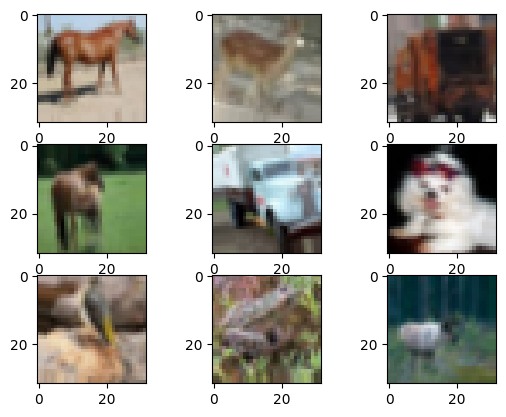

In [5]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [6]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [8]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [9]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [19]:
# build and compile the model  (roughly following the VGG paper)
input_shape=(img_rows, img_cols, channels)
#reg=l2(1e-4)   # L2 or "ridge" regularisation

#the model has 6 convolutional layers, 1 flatten layer, and 2 dense layers, making it a total of 9 layers.
# Smaller than Vgg-16

reg=None
num_filters=32
ac='relu'
adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # Removed the 'decay' argument
opt=adm
drop_dense=0.5
drop_conv=0

# Define model
model = Sequential()

# Convolutional layers
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Conv2D(2 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Conv2D(4 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation=ac, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))  # 10 classes for MNIST dataset

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [21]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 19s 21ms/step - loss: 1.4711 - accuracy: 0.5162 - val_loss: 1.2468 - val_accuracy: 0.5581
Epoch 2/10
391/391 [==============================] - 6s 16ms/step - loss: 0.8731 - accuracy: 0.6913 - val_loss: 0.7793 - val_accuracy: 0.7245
Epoch 3/10
391/391 [==============================] - 6s 16ms/step - loss: 0.6883 - accuracy: 0.7579 - val_loss: 0.7272 - val_accuracy: 0.7452
Epoch 4/10
391/391 [==============================] - 8s 20ms/step - loss: 0.5719 - accuracy: 0.7990 - val_loss: 0.6642 - val_accuracy: 0.7732
Epoch 5/10
391/391 [==============================] - 7s 17ms/step - loss: 0.4872 - accuracy: 0.8303 - val_loss: 0.6598 - val_accuracy: 0.7809
Epoch 6/10
391/391 [==============================] - 6s 16ms/step - loss: 0.4095 - accuracy: 0.8576 - val_loss: 0.6354 - val_accuracy: 0.7921
Epoch 7/10
391/391 [==============================] - 7s 17ms/step - loss: 0.3326 - accuracy: 0.8830 - val_loss: 0.6912 - val_accuracy: 0.784

313/313 [==============================] - 1s 2ms/step
Train Set Confusion Matrix:
[[4580   37  212   31   11   13    9   38   50   19]
 [   2 4967    8    3    1    3    0    4    5    7]
 [  24    2 4817   46   18   35   32   18    1    7]
 [   4    3   89 4450   34  310   17   78    8    7]
 [  10    4  147   79 4540  102   22   86    8    2]
 [   6    1   51   86   10 4799    1   43    0    3]
 [   6   28  112   84   15   64 4652   23   10    6]
 [   5    0   35   20   18   62    1 4854    1    4]
 [  42   69   31   11    0    6    1   10 4806   24]
 [  18  284    8    8    2   16    0   22    7 4635]]

Test Set Confusion Matrix:
[[748  32  97  19  15   6   4  17  37  25]
 [  5 923  10   6   2   9   1   6   7  31]
 [ 23   4 774  50  40  52  25  28   3   1]
 [  7   5  89 605  34 194  19  35  10   2]
 [ 16   4 101  61 672  56  28  55   6   1]
 [  6   2  41 108  16 775   5  40   2   5]
 [  4   7  63  54   9  42 797  12   7   5]
 [  5   1  34  32  25  70   2 824   1   6]
 [ 37  40  18 

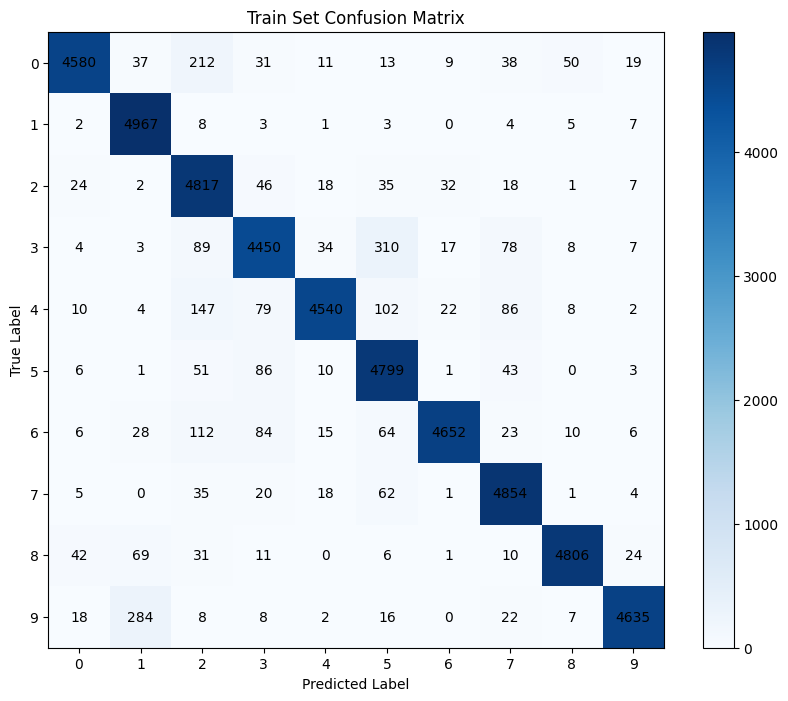

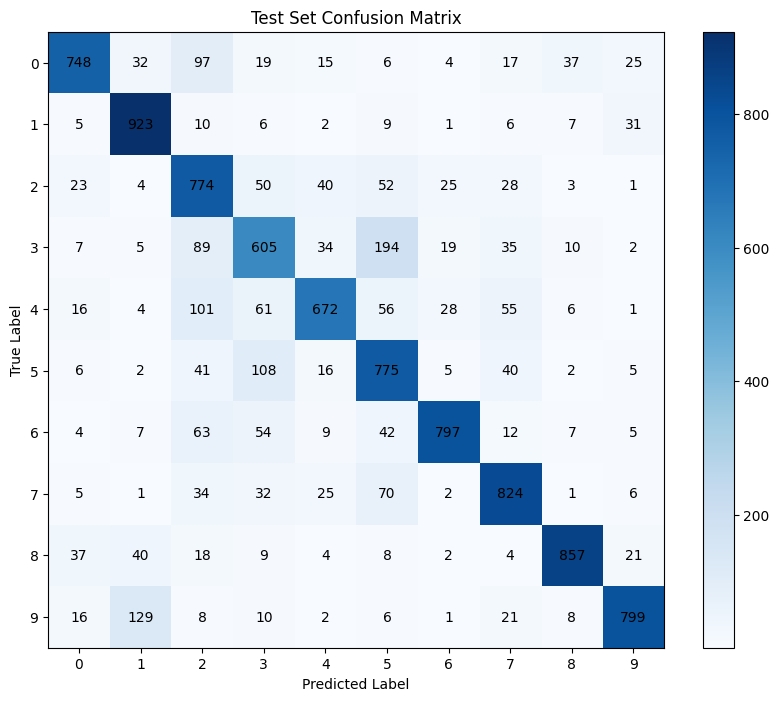


Train Set Accuracy: [0.5162400007247925, 0.6913400292396545, 0.7578799724578857, 0.7989799976348877, 0.8302800059318542, 0.8575800061225891, 0.8829600214958191, 0.9019200205802917, 0.9157599806785583, 0.9278799891471863]
Train Set Recall: 0.942
Train Set Precision: 0.942
Train Set F1-Score: 0.942

Test Set Accuracy: [0.5580999851226807, 0.7245000004768372, 0.745199978351593, 0.7731999754905701, 0.7809000015258789, 0.7921000123023987, 0.7846999764442444, 0.7810999751091003, 0.7929999828338623, 0.777400016784668]
Test Set Recall: 0.7774
Test Set Precision: 0.7774
Test Set F1-Score: 0.7774


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy for train and test sets in each iteration
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# Calculate recall, precision, and f1-score for each set
train_predictions = np.argmax(model.predict(x_train), axis=1)
test_predictions = np.argmax(model.predict(x_test), axis=1)

train_recall = recall_score(np.argmax(y_train, axis=1), train_predictions, average='micro')
train_precision = precision_score(np.argmax(y_train, axis=1), train_predictions, average='micro')
train_f1 = f1_score(np.argmax(y_train, axis=1), train_predictions, average='micro')

test_recall = recall_score(np.argmax(y_test, axis=1), test_predictions, average='micro')
test_precision = precision_score(np.argmax(y_test, axis=1), test_predictions, average='micro')
test_f1 = f1_score(np.argmax(y_test, axis=1), test_predictions, average='micro')

# Print confusion matrices for each set
print("Train Set Confusion Matrix:")
train_cm = confusion_matrix(np.argmax(y_train, axis=1), train_predictions)
print(train_cm)

print("\nTest Set Confusion Matrix:")
test_cm = confusion_matrix(np.argmax(y_test, axis=1), test_predictions)
print(test_cm)

# Plot confusion matrices as numbers
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plot_confusion_matrix(train_cm, 'Train Set Confusion Matrix')
plt.show()

plot_confusion_matrix(test_cm, 'Test Set Confusion Matrix')
plt.show()

# Print results
print('\nTrain Set Accuracy:', train_acc)
print('Train Set Recall:', train_recall)
print('Train Set Precision:', train_precision)
print('Train Set F1-Score:', train_f1)

print('\nTest Set Accuracy:', test_acc)
print('Test Set Recall:', test_recall)
print('Test Set Precision:', test_precision)
print('Test Set F1-Score:', test_f1)


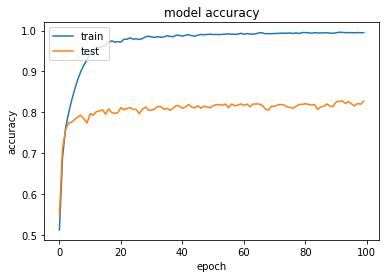

In [ ]:
plothist(history)

## Mnist Dataset

In [31]:

# Load MNIST dataset
mnist = tf.keras.datasets.mnist

# Split the dataset into training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Print the shapes of training and testing sets
print("Training set shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing set shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
Training set shape: (60000, 28, 28)
Training labels shape: (60000, 10)
Testing set shape: (10000, 28, 28)
Testing labels shape: (10000, 10)


In [36]:
# build and compile the model  (roughly following the VGG paper)
input_shape=(img_rows, img_cols, channels)
#reg=l2(1e-4)   # L2 or "ridge" regularisation

#the model has 6 convolutional layers, 1 flatten layer, and 2 dense layers, making it a total of 9 layers.
# Smaller than Vgg-16

reg=None
num_filters=32
ac='relu'
adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # Removed the 'decay' argument
opt=adm
drop_dense=0.5
drop_conv=0

# Define model
model = Sequential()

# Convolutional layers
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Conv2D(2 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Conv2D(4 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4 * num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation=ac, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))  # 10 classes for MNIST dataset

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                      

In [38]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 13s 17ms/step - loss: 0.1094 - accuracy: 0.9667 - val_loss: 0.3854 - val_accuracy: 0.8784
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 0.0347 - accuracy: 0.9889 - val_loss: 0.0326 - val_accuracy: 0.9894
Epoch 3/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0317 - val_accuracy: 0.9895
Epoch 4/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.0460 - val_accuracy: 0.9874
Epoch 5/10
469/469 [==============================] - 6s 14ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0456 - val_accuracy: 0.9856
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 0.0405 - val_accuracy: 0.9899
Epoch 7/10
469/469 [==============================] - 6s 14ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0381 - val_accuracy: 0.989

313/313 [==============================] - 1s 2ms/step
Train Set Confusion Matrix:
[[5910    0    0    0    4    0    1    0    0    8]
 [   0 6742    0    0    0    0    0    0    0    0]
 [   2   14 5931    0    2    0    1    5    0    3]
 [   1    5    1 6111    0    0    0    2    0   11]
 [   0    4    0    0 5824    0    0   11    0    3]
 [   4    2    0    4    4 5377    2    0    0   28]
 [   0    0    0    0    8    1 5909    0    0    0]
 [   0   22    2    0    0    0    0 6225    0   16]
 [   8   12    4    0    8    2    3    4 5784   26]
 [   0    3    0    0    8    0    0    2    0 5936]]

Test Set Confusion Matrix:
[[ 977    0    0    0    1    0    0    0    0    2]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   2    3 1020    1    1    0    1    3    0    1]
 [   0    0    0 1007    0    1    0    0    0    2]
 [   0    0    0    0  978    0    0    1    0    3]
 [   1    0    0    8    0  877    1    1    0    4]
 [   1    3    0    0    5    2  947    

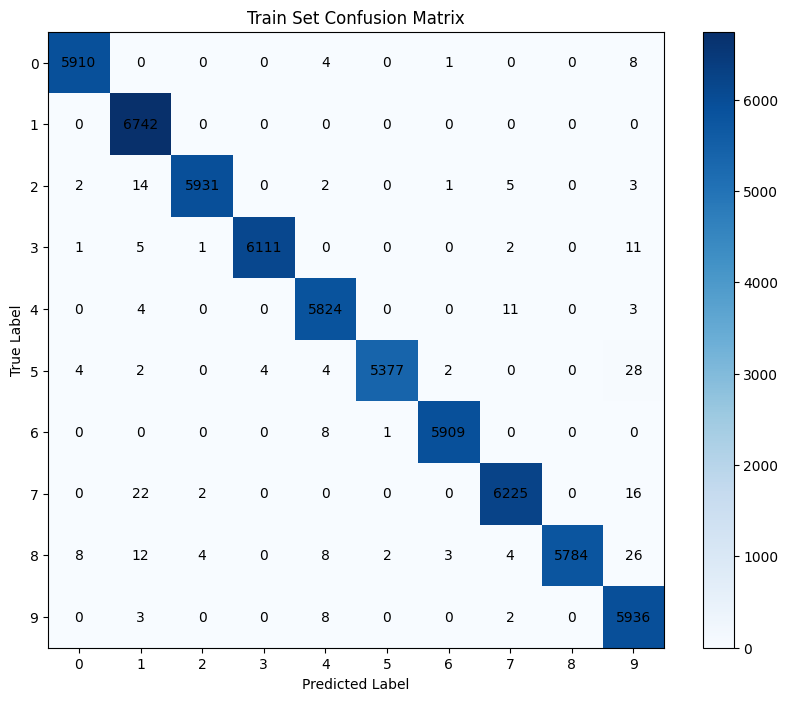

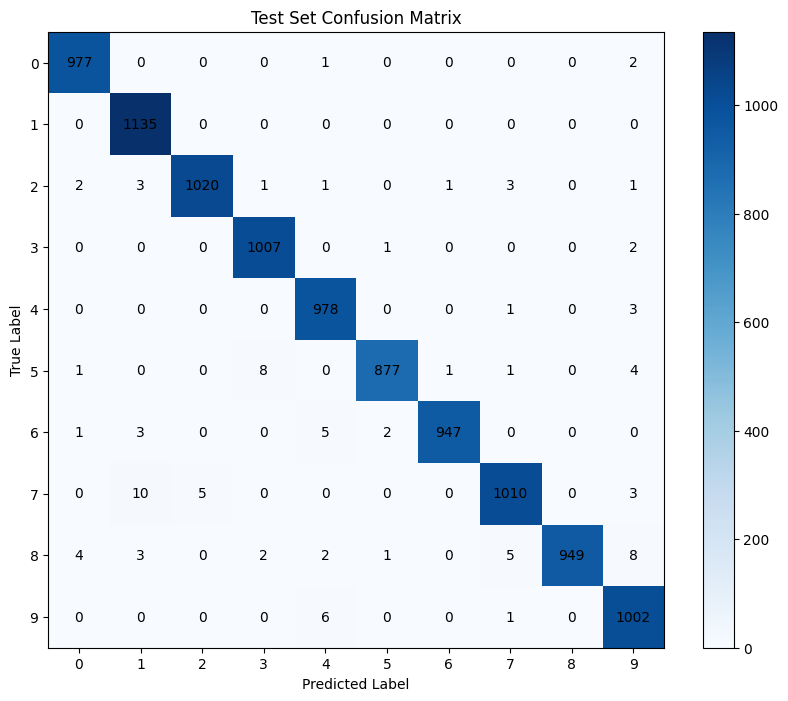


Train Set Accuracy: [0.9666666388511658, 0.9889000058174133, 0.9926166534423828, 0.9936833381652832, 0.9944000244140625, 0.9945166707038879, 0.9940833449363708, 0.9959666728973389, 0.9963833093643188, 0.9962999820709229]
Train Set Recall: 0.9958166666666667
Train Set Precision: 0.9958166666666667
Train Set F1-Score: 0.9958166666666667

Test Set Accuracy: [0.8784000277519226, 0.9894000291824341, 0.9894999861717224, 0.9873999953269958, 0.9855999946594238, 0.9898999929428101, 0.989799976348877, 0.9909999966621399, 0.989799976348877, 0.9901999831199646]
Test Set Recall: 0.9902
Test Set Precision: 0.9902
Test Set F1-Score: 0.9902


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy for train and test sets in each iteration
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# Calculate recall, precision, and f1-score for each set
train_predictions = np.argmax(model.predict(x_train), axis=1)
test_predictions = np.argmax(model.predict(x_test), axis=1)

train_recall = recall_score(np.argmax(y_train, axis=1), train_predictions, average='micro')
train_precision = precision_score(np.argmax(y_train, axis=1), train_predictions, average='micro')
train_f1 = f1_score(np.argmax(y_train, axis=1), train_predictions, average='micro')

test_recall = recall_score(np.argmax(y_test, axis=1), test_predictions, average='micro')
test_precision = precision_score(np.argmax(y_test, axis=1), test_predictions, average='micro')
test_f1 = f1_score(np.argmax(y_test, axis=1), test_predictions, average='micro')

# Print confusion matrices for each set
print("Train Set Confusion Matrix:")
train_cm = confusion_matrix(np.argmax(y_train, axis=1), train_predictions)
print(train_cm)

print("\nTest Set Confusion Matrix:")
test_cm = confusion_matrix(np.argmax(y_test, axis=1), test_predictions)
print(test_cm)

# Plot confusion matrices as numbers
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plot_confusion_matrix(train_cm, 'Train Set Confusion Matrix')
plt.show()

plot_confusion_matrix(test_cm, 'Test Set Confusion Matrix')
plt.show()

# Print results
print('\nTrain Set Accuracy:', train_acc)
print('Train Set Recall:', train_recall)
print('Train Set Precision:', train_precision)
print('Train Set F1-Score:', train_f1)

print('\nTest Set Accuracy:', test_acc)
print('Test Set Recall:', test_recall)
print('Test Set Precision:', test_precision)
print('Test Set F1-Score:', test_f1)
